# PCA

## Explained Variance of Each PC
We mentioned that PCA will order the principal components, with the first PC giving the direction of maximal variance, second PC has second-largest variance, and so on. **How much of the variance is explained by the first principal component? The second?**


Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.066s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.010s
Fitting the classifier to the training set
done in 13.485s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting the people names on the testing set
done in 0.040s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.80      0.88      0.84        60
  Donald Rumsfeld       0.94      0.63 

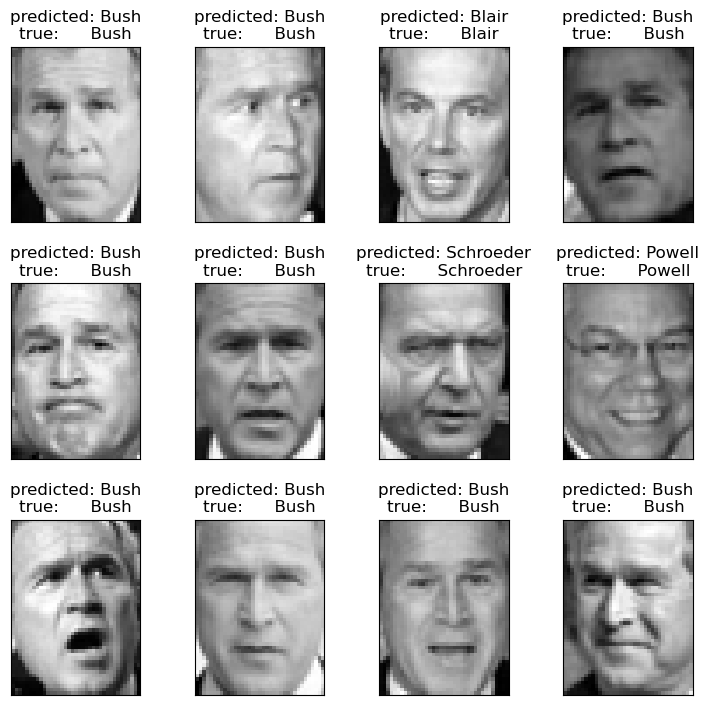

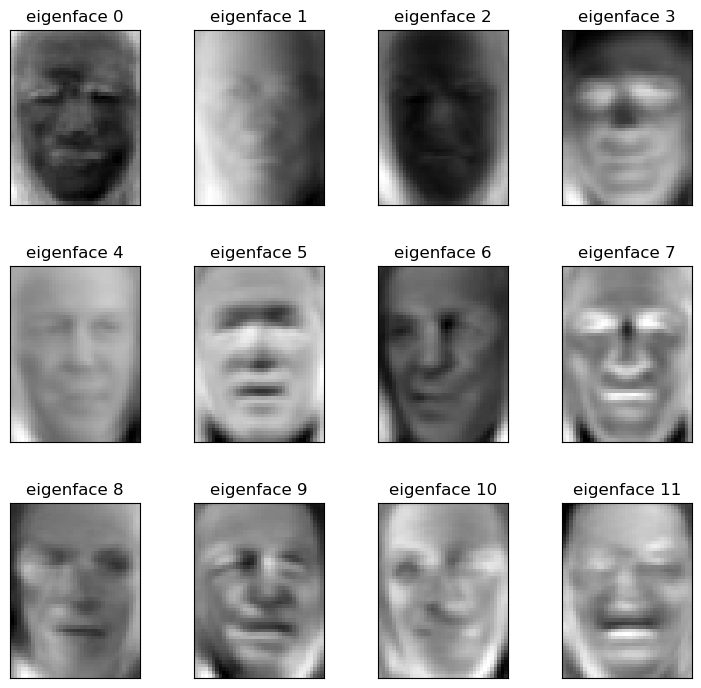

In [1]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""



print(__doc__)

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model(
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
          'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                      for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


How much of the variance is explained by the first principal component? The second?

In [2]:
print(pca.explained_variance_ratio_[0])
print(pca.explained_variance_ratio_[1])

0.2086376
0.14047958


## How Many PCs to Use?

Now you'll experiment with keeping different numbers of principal components. In a multiclass classification problem like this one (more than 2 labels to apply), accuracy is a less-intuitive metric than in the 2-class case. Instead, a popular metric is the F1 score.

We’ll learn about the F1 score properly in the lesson on evaluation metrics, but you’ll figure out for yourself whether a good classifier is characterized by a high or low F1 score. You’ll do this by varying the number of principal components and watching how the F1 score changes in response.

**As you add more principal components as features for training your classifier, do you expect it to get better or worse performance?**

1. Try to change the n_components to 200


Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 200 eigenfaces from 966 faces
done in 0.090s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.007s
Fitting the classifier to the training set
done in 16.137s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.001)
Predicting the people names on the testing set
done in 0.038s
                   precision    recall  f1-score   support

     Ariel Sharon       0.57      0.62      0.59        13
     Colin Powell       0.74      0.88      0.80        60
  Donald Rumsfeld       0.77      0.74 

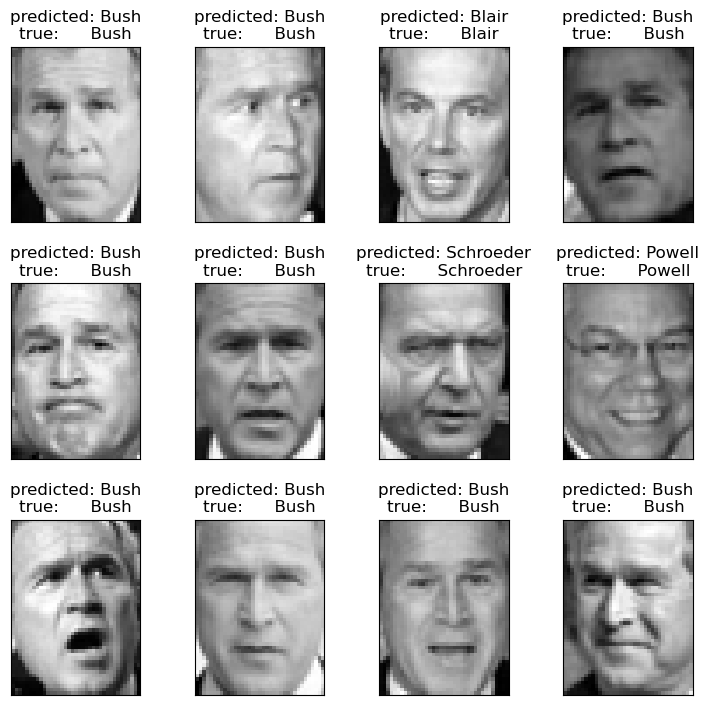

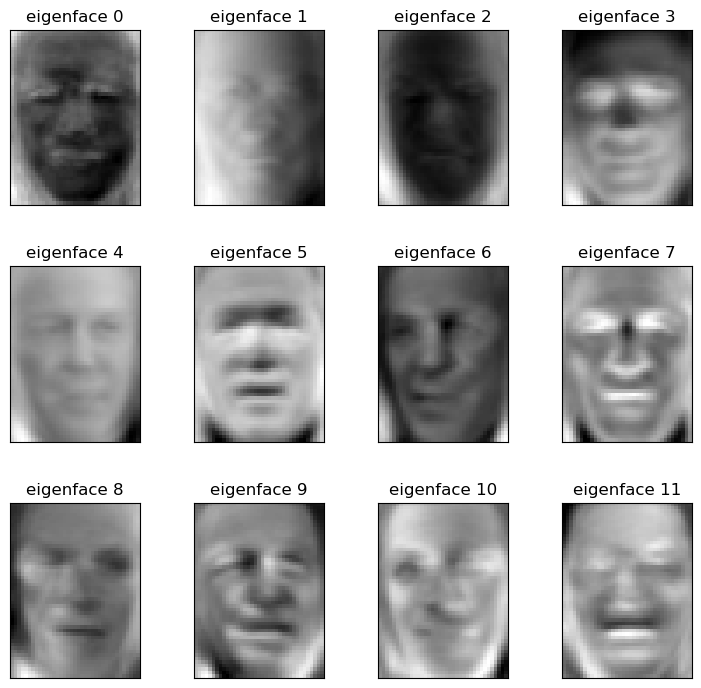

In [4]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""



print(__doc__)

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 200

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model(
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
          'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                      for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


2. Try to change the n_components to 100


Faces recognition example using eigenfaces and SVMs

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 100 eigenfaces from 966 faces
done in 0.041s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.009s
Fitting the classifier to the training set
done in 11.077s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)
Predicting the people names on the testing set
done in 0.049s
                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.69      0.72        13
     Colin Powell       0.82      0.88      0.85        60
  Donald Rumsfeld       0.71      0.63 

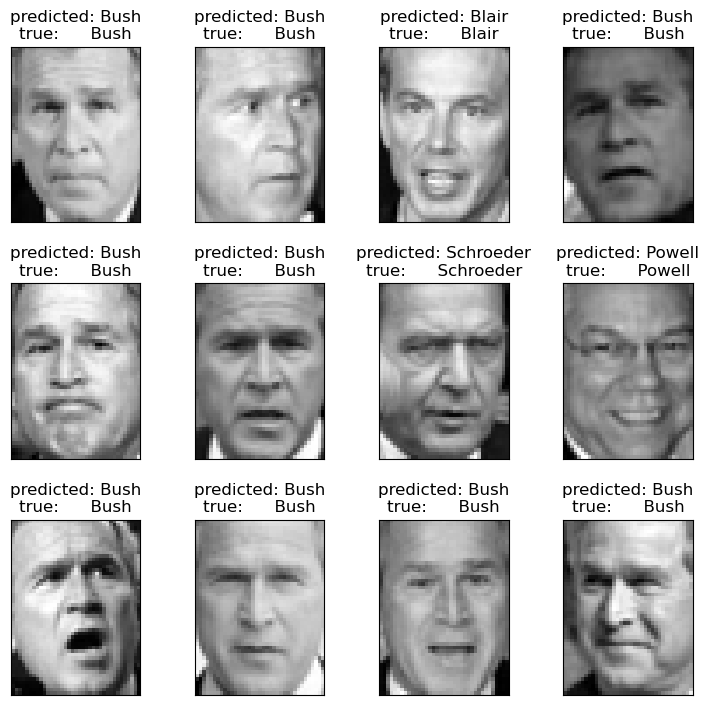

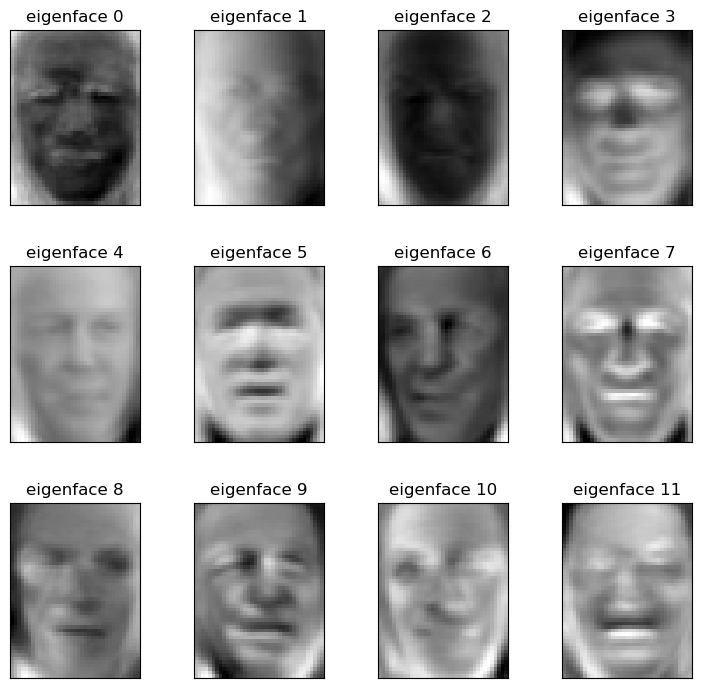

In [5]:
"""
===================================================
Faces recognition example using eigenfaces and SVMs
===================================================

The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  .. _LFW: http://vis-www.cs.umass.edu/lfw/

  original source: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html

"""



print(__doc__)

from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

###############################################################################
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 100

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))


###############################################################################
# Train a SVM classification model(
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {
          'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)


###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


###############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                      for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()


Whether we increase or decrease the components does not significantly affect accuracy.

While ideally, adding components should provide us additional signal to improve our performance, it is possible that we end up at a complexity where we overfit.

## F1 Score vs. No. of PCs Used

Change n_components to the following values: [10, 15, 25, 50, 100, 250]. For each number of principal components, note the F1 score for Ariel Sharon. (For 10 PCs, the plotting functions in the code will break, but you should be able to see the F1 scores.) **If you see a higher F1 score, does it mean the classifier is doing better, or worse?**

1. f1_PCA_10 = 0.18
2. f1_PCA_15 = 0.52
3. f1_PCA_25 = 0.47
4. f1_PCA_50 = 0.77
5. f1_PCA_100 = 0.72
6. f1_PCA_250 = 0.69

Adding more components may increase the F1 score, but since it arrives at a limit, more PCA decreases the F1 score.

## Selecting Principal Components

Selecting a number of principal components

Quiz: What's a good way to figure out how many PCs to use?

Train on different number of PCs, and see how accuracy responds -- cut off when it becomes apparent that adding more PCs doesn't buy you much more dicrimination.